# INLP - Assignment 2
## Harshavardhan P - 2021111003

In [39]:
import torch
import torch.nn as nn
import conllu
import pandas as pd
import gensim.downloader as api
from torch.utils.data import Dataset, DataLoader
import pprint as pp
import numpy as np
import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
device = ''
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
print(device)

cpu


# Flow - 2

## Dataset

### Importing data file

In [42]:
# import the data files
dataset_path_train = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu'
dataset_path_dev = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu'
dataset_path_test = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu'

dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

# create a dataframe from the data
def create_dataframe(dataset):
    data = []
    for tokenlist in dataset:
        for token in tokenlist:
            # data.append([token['form'], token['upostag']])
            data.append([token['form'], token['upostag']])
    # return pd.DataFrame(data, columns=['', 'word', 'pos'])
    return pd.DataFrame(data, columns=['word', 'pos'])

df_train = create_dataframe(dataset_train)
df_dev = create_dataframe(dataset_dev)
df_test = create_dataframe(dataset_test)

print(df_train.head())
print(df_dev.head())
print(df_test.head())

   word   pos
0  what  PRON
1    is   AUX
2   the   DET
3  cost  NOUN
4    of   ADP
       word   pos
0         i  PRON
1     would   AUX
2      like  VERB
3       the   DET
4  cheapest   ADJ
      word   pos
0     what  PRON
1      are   AUX
2      the   DET
3    coach  NOUN
4  flights  NOUN


In [43]:
df = df_train
vocab = set(df['word'])
pos_tags = set(df['pos'])
word_vectors_all = api.load('glove-wiki-gigaword-100')

### Preprocess the data

In [44]:
def preprocess_train(df, embedding_type='glove-wiki-gigaword-100'):
    vocab = set(df['word'])
    pos_tags = set(df['pos'])
    word_vectors_all = api.load(embedding_type)

    word_vectors = {}
    for word in vocab:
        if word in word_vectors_all:
            word_vectors[word] = word_vectors_all[word]
        else:
            word_vectors[word] = np.zeros(len(word_vectors_all['the']))

        # one hot encode the pos tags
    pos_tags_one_hot = {}
    for i, tag in enumerate(pos_tags):
        one_hot = np.zeros(len(pos_tags) + 1)
        one_hot[i] = 1
        pos_tags_one_hot[tag] = one_hot
    pos_tags_one_hot[''] = np.zeros(len(pos_tags) + 1)
    pos_tags_one_hot[''][-1] = 1

    # convert the df to list
    data = df.values.tolist()
    dataset = [[word_vectors[data[i][0]], pos_tags_one_hot[data[i][1]]] for i in range(len(data))]

    return dataset, word_vectors, pos_tags_one_hot

In [45]:
def preprocess_dev_test(df, word_vectors, pos_tags_one_hot):
    data = df.values.tolist()

    dataset = []
    for i in range(len(data)):
        word = data[i][0]
        if word in word_vectors:
            word_vector = word_vectors[word]
        else:
            word_vector = np.zeros(len(word_vectors['the']))
        if data[i][1] in pos_tags_one_hot:
            pos_vector = pos_tags_one_hot[data[i][1]]
        else:
            pos_vector = pos_tags_one_hot['']
        dataset.append([word_vector, pos_vector])

    return dataset

### Creating Dataset and loading

In [46]:
class CoNLLUDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_vector = self.dataset[idx][0]
        output_vector = self.dataset[idx][1]
        return input_vector, output_vector

In [47]:
train_data, word_vectors, pos_tags_one_hot = preprocess_train(df_train)
dev_data = preprocess_dev_test(df_dev, word_vectors, pos_tags_one_hot)
test_data = preprocess_dev_test(df_test, word_vectors, pos_tags_one_hot)

In [48]:
train_conllu_dataset = CoNLLUDataset(train_data)
dev_conllu_dataset = CoNLLUDataset(dev_data)
test_conllu_dataset = CoNLLUDataset(test_data)

train_loader = DataLoader(train_conllu_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_conllu_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_conllu_dataset, batch_size=32, shuffle=True)

## Models

### RNN

In [49]:
# creating an RNN which takes n dim input and returns pos tag vector
class RNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

## Training

In [50]:
# Loss for classification
criterion = nn.BCELoss()

def train_model(model, dataloader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch: {epoch}, Loss: {running_loss / len(dataloader)}')

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    print(f'Loss: {running_loss / len(dataloader)}')
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_preds = all_preds.argmax(axis=1)
    all_labels = all_labels.argmax(axis=1)
    print(f'Accuracy: {accuracy_score(all_labels, all_preds)}')
    print(f'Precision: {precision_score(all_labels, all_preds, average="weighted")}')
    print(f'Recall: {recall_score(all_labels, all_preds, average="weighted")}')
    print(f'F1: {f1_score(all_labels, all_preds, average="weighted")}')
    return all_labels, all_preds

# Train the model
model = RNN(100, 100, len(pos_tags_one_hot))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, 10, optimizer, criterion)

# Evaluate the model
all_labels, all_preds = evaluate_model(model, dev_loader, criterion)

Epoch: 0, Loss: 0.04050808957836699
Epoch: 1, Loss: 0.02081149911375093
Epoch: 2, Loss: 0.018400817108922256
Epoch: 3, Loss: 0.017536231405410933
Epoch: 4, Loss: 0.01684209633677375
Epoch: 5, Loss: 0.016426075518446288
Epoch: 6, Loss: 0.015941046073215046
Epoch: 7, Loss: 0.015703355029638964
Epoch: 8, Loss: 0.015553262761133042
Epoch: 9, Loss: 0.015291220115547153
Loss: 0.01847691132206819
Accuracy: 0.9574051776038531
Precision: 0.9479596221066687
Recall: 0.9574051776038531
F1: 0.9517832612114447


# Flow - 1

## Dataset

### Importing data file

In [51]:
# import the data files
dataset_path_train = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu'
dataset_path_dev = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu'
dataset_path_test = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu'

dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

# create a dataframe from the data
def create_dataframe(dataset):
    data = []
    for tokenlist in dataset:
        for token in tokenlist:
            # data.append([token['form'], token['upostag']])
            data.append([token['id'], token['form'], token['upostag']])
    # return pd.DataFrame(data, columns=['', 'word', 'pos'])
    return pd.DataFrame(data, columns=['id', 'word', 'pos'])

df_train = create_dataframe(dataset_train)
df_dev = create_dataframe(dataset_dev)
df_test = create_dataframe(dataset_test)

print(df_train.head())
print(df_dev.head())
print(df_test.head())

   id  word   pos
0   1  what  PRON
1   2    is   AUX
2   3   the   DET
3   4  cost  NOUN
4   5    of   ADP
   id      word   pos
0   1         i  PRON
1   2     would   AUX
2   3      like  VERB
3   4       the   DET
4   5  cheapest   ADJ
   id     word   pos
0   1     what  PRON
1   2      are   AUX
2   3      the   DET
3   4    coach  NOUN
4   5  flights  NOUN


In [52]:
df = df_train
vocab = set(df['word'])
pos_tags = set(df['pos'])
word_vectors_all = api.load('glove-wiki-gigaword-100')

### Preprocess the data

In [53]:
# function to find vocabulary and POS tags, as well as load the word embeddings to be used
def preprocess_train(df, p=3, s=3, embedding_type='glove-wiki-gigaword-100'):
    vocab = set(df['word'])
    pos_tags = set(df['pos'])
    word_vectors_all = api.load(embedding_type)

    word_vectors = {}
    for word in vocab:
        if word in word_vectors_all:
            word_vectors[word] = word_vectors_all[word]
        else:
            word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

    # one hot encode the POS tags
    pos_tags_one_hot = {}
    for i, tag in enumerate(pos_tags):
        one_hot = torch.zeros(len(pos_tags) + 1)
        one_hot[i] = 1
        pos_tags_one_hot[tag] = one_hot
    pos_tags_one_hot[''] = torch.zeros(len(pos_tags) + 1)
    pos_tags_one_hot[''][-1] = 1

    # convert the df to list
    data = df.values.tolist()
    dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    # pp.pprint(dataset)

    max = 0
    for i in range(len(dataset)):
        if data[i][0] > max:
            max = data[i][0]

    split_dataset = []
    curr = 0
    for i in range(1, len(dataset)):
        if data[i][0] == 1:
            split_dataset.append(dataset[curr:i])
            curr = i
    split_dataset.append(dataset[curr:])
    # print(len(split_dataset))
    # print(max)

    final_dataset = []
    for i in range(len(split_dataset)):
        dataset = split_dataset[i]
        dataset1 = dataset.copy()
        dataset2 = dataset.copy()
        for j in range(p):
            dataset1 = dataset1[:-1]
            dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
            dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
        for j in range(s):
            dataset2 = dataset2[1:]
            dataset2 = np.append(dataset2, [np.zeros(len(word_vectors_all['the']))], axis=0)
            dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
        final_dataset.append(dataset)

    # pp.pprint(final_dataset[0][0])
    # pp.pprint(final_dataset[0][-1])

    dataset = []
    for lst in final_dataset:
        dataset.extend(lst)
    dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
    print(dataset.shape)

    final_dataset = []
    for i in range(len(dataset)):
        final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])

    print(len(final_dataset))
    print(len(final_dataset[0]))
    print(len(final_dataset[0][0]))
    print(len(final_dataset[0][1]))
    # print(type(final_dataset[0][0]))
    # print(type(final_dataset[0][1]))
    # print(final_dataset[22][0])
    # print(final_dataset[0][1])

    return final_dataset, word_vectors, pos_tags_one_hot

In [54]:
# function to preprocess the dev and test data, using the word vectors and POS tags from the training data
def preprocess_dev_test(df, word_vectors, pos_tags_one_hot, p=3, s=3):
    data = df.values.tolist()
    # dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    dataset = []
    for i in range(len(data)):
        if data[i][1] in word_vectors:
            dataset.append(word_vectors[data[i][1]])
        else:
            dataset.append(torch.zeros(len(word_vectors['the'])))
    dataset = np.array(dataset, dtype=np.float32)
    # pp.pprint(dataset)

    max = 0
    for i in range(len(dataset)):
        if data[i][0] > max:
            max = data[i][0]

    split_dataset = []
    curr = 0
    for i in range(1, len(dataset)):
        if data[i][0] == 1:
            split_dataset.append(dataset[curr:i])
            curr = i
    split_dataset.append(dataset[curr:])
    # print(len(split_dataset))
    # print(max)

    final_dataset = []
    for i in range(len(split_dataset)):
        dataset = split_dataset[i]
        dataset1 = dataset.copy()
        dataset2 = dataset.copy()
        for j in range(p):
            dataset1 = dataset1[:-1]
            dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors['the']))], axis=0)
            dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
        for j in range(s):
            dataset2 = dataset2[1:]
            dataset2 = np.append(dataset2, [np.zeros(len(word_vectors['the']))], axis=0)
            dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
        final_dataset.append(dataset)

    # pp.pprint(final_dataset[0][0])
    # pp.pprint(final_dataset[0][-1])

    dataset = []
    for lst in final_dataset:
        dataset.extend(lst)
    dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
    print(dataset.shape)

    final_dataset = []
    for i in range(len(dataset)):
        # final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])
        tensor1 = torch.tensor(dataset[i][0])
        try:
            tensor2 = pos_tags_one_hot[data[i][2]]
        except:
            tensor2 = pos_tags_one_hot['']
        final_dataset.append([tensor1, tensor2])

    print(len(final_dataset))
    print(len(final_dataset[0]))
    print(len(final_dataset[0][0]))
    print(len(final_dataset[0][1]))
    # print(type(final_dataset[0][0]))
    # print(type(final_dataset[0][1]))
    # print(final_dataset[22][0])
    # print(final_dataset[0][1])

    return final_dataset

### Creating Dataset and loading

In [55]:
class CoNLLUDataset(Dataset):
    def __init__(self, data):
        self.dataset = data

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # input_tensor = torch.tensor(self.dataset[idx][0], dtype=torch.float32, device=device)
        input_tensor = self.dataset[idx][0].to(device)
        # target_tensor = torch.tensor(self.dataset[idx][1], dtype=torch.float32, device=device)
        target_tensor = self.dataset[idx][1].to(device)
        return input_tensor, target_tensor

In [56]:
# preprocess the data
train_data, word_vectors, pos_tags_one_hot = preprocess_train(df_train)
dev_data = preprocess_dev_test(df_dev, word_vectors, pos_tags_one_hot)
test_data = preprocess_dev_test(df_test, word_vectors, pos_tags_one_hot)

# create the dataloaders
train_conllu_dataset = CoNLLUDataset(train_data)
dev_conllu_dataset = CoNLLUDataset(dev_data)
test_conllu_dataset = CoNLLUDataset(test_data)

train_dataloader = DataLoader(train_conllu_dataset, batch_size=64, shuffle=True)
dev_dataloader = DataLoader(dev_conllu_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_conllu_dataset, batch_size=64, shuffle=True)

(48655, 1, 700)
48655
2
700
14
(6644, 1, 700)
6644
2
700
14
(6580, 1, 700)
6580
2
700
14


## Models

### FNN

In [57]:
# creating an FNN which takes n dim input and returns pos tag vector
class FNN(nn.Module):
    def __init__(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
        super(FNN, self).__init__()
        # for each element in hidden_params, we will create a linear layer
        hidden_layers = []
        hidden_layers.append(nn.Linear(embed_dim * (prev_n + 1 + succ_n), hidden_params[0]))
        hidden_layers.append(nn.ReLU())
        for i in range(1, len(hidden_params)):
            hidden_layers.append(nn.Linear(hidden_params[i-1], hidden_params[i]))
            hidden_layers.append(nn.ReLU())
        # softmax layer for output
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_params[-1], output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

## Training

Epoch 1


100%|██████████| 761/761 [00:00<00:00, 1243.43it/s]


Epoch 1, loss: 0.06294232297507599
Epoch 2


100%|██████████| 761/761 [00:00<00:00, 1296.39it/s]


Epoch 2, loss: 0.01834471497296768
Epoch 3


100%|██████████| 761/761 [00:00<00:00, 1312.14it/s]


Epoch 3, loss: 0.013945934147547695
Epoch 4


100%|██████████| 761/761 [00:00<00:00, 1306.77it/s]


Epoch 4, loss: 0.012291995934382051
Epoch 5


100%|██████████| 761/761 [00:00<00:00, 1316.90it/s]


Epoch 5, loss: 0.011048197265929798
Epoch 6


100%|██████████| 761/761 [00:00<00:00, 1309.19it/s]


Epoch 6, loss: 0.010227406191708135
Epoch 7


100%|██████████| 761/761 [00:00<00:00, 1315.44it/s]


Epoch 7, loss: 0.00956300159065119
Epoch 8


100%|██████████| 761/761 [00:00<00:00, 1310.80it/s]


Epoch 8, loss: 0.00933217855935865
Epoch 9


100%|██████████| 761/761 [00:00<00:00, 1337.46it/s]


Epoch 9, loss: 0.008715343046792674
Epoch 10


100%|██████████| 761/761 [00:00<00:00, 1326.23it/s]


Epoch 10, loss: 0.008524825179070704
Epoch 11


100%|██████████| 761/761 [00:00<00:00, 1222.78it/s]


Epoch 11, loss: 0.008333699633082822
Epoch 12


100%|██████████| 761/761 [00:00<00:00, 1328.76it/s]


Epoch 12, loss: 0.008177918466221836
Epoch 13


100%|██████████| 761/761 [00:00<00:00, 1322.63it/s]


Epoch 13, loss: 0.008006280092748907
Epoch 14


100%|██████████| 761/761 [00:00<00:00, 1121.33it/s]


Epoch 14, loss: 0.007875322624025242
Epoch 15


100%|██████████| 761/761 [00:00<00:00, 1324.22it/s]


Epoch 15, loss: 0.007768998321503126
Epoch 16


100%|██████████| 761/761 [00:00<00:00, 1310.01it/s]


Epoch 16, loss: 0.007626331794585386
Epoch 17


100%|██████████| 761/761 [00:00<00:00, 1268.42it/s]


Epoch 17, loss: 0.007518779004464457
Epoch 18


100%|██████████| 761/761 [00:00<00:00, 1319.90it/s]


Epoch 18, loss: 0.0074832055258164465
Epoch 19


100%|██████████| 761/761 [00:00<00:00, 1309.26it/s]


Epoch 19, loss: 0.007388393546554961
Epoch 20


100%|██████████| 761/761 [00:00<00:00, 1326.73it/s]


Epoch 20, loss: 0.007197025139925025


100%|██████████| 103/103 [00:00<00:00, 2602.32it/s]



Loss: 0.00977199338376522

Accuracy: 0.9790273556231003
Precision: 0.9787557668916996
Recall: 0.9790273556231003
F1 Score: 0.978636193731978


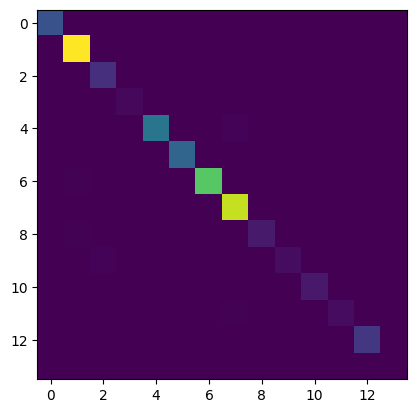

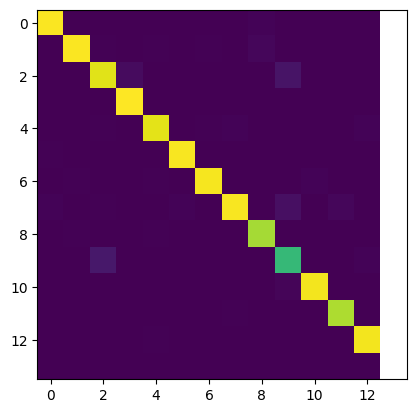

100%|██████████| 104/104 [00:00<00:00, 2220.71it/s]


Loss: 0.011737177610204807

Accuracy: 0.9718543046357616
Precision: 0.9713818377510385
Recall: 0.9718543046357616
F1 Score: 0.9714265129524949


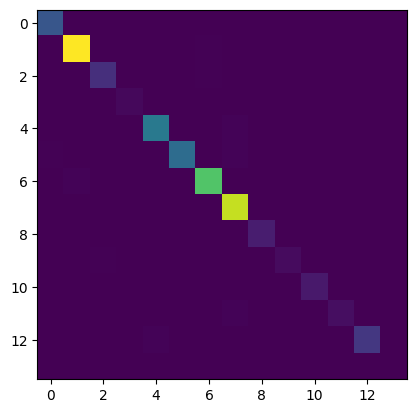

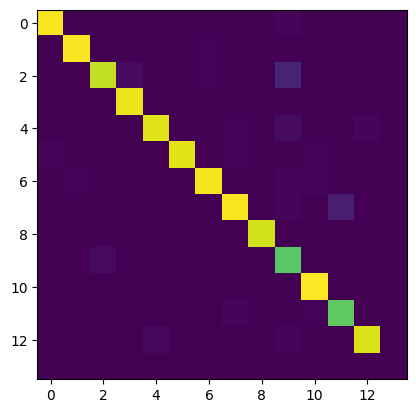

In [58]:
# Loss for classification
criterion = nn.BCELoss()

# function to train the model
def train_model(model, dataloader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        running_loss = 0.0
        # for i, data in enumerate(dataloader, 0):
        for i, data in enumerate(tqdm.tqdm(dataloader, position=0, leave=True), 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(dataloader)}")

# function to test the model
def test_model(model, dataloader, criterion, pos_tags_one_hot):
    # find loss, accuracy, precision, recall, f1 score
    model.eval()
    running_loss = 0.0
    total_outputs = []
    total_labels = []
    with torch.no_grad():
        # for data in dataloader:
        for data in tqdm.tqdm(dataloader, position=0, leave=True):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            outputs_copy = outputs.clone().detach().cpu().numpy()
            outputs_one_hot = np.zeros(outputs_copy.shape)
            outputs_one_hot[np.arange(outputs_copy.shape[0]), np.argmax(outputs_copy, axis=1)] = 1

            total_outputs.extend(outputs_one_hot)
            total_labels.extend(labels.clone().detach().cpu().numpy())

    total_outputs = np.array(total_outputs)
    total_labels = np.array(total_labels)

    print()
    print(f"Loss: {running_loss/len(dataloader)}")
    print()
    print(f"Accuracy: {accuracy_score(total_labels, total_outputs)}")
    print(f"Precision: {precision_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
    print(f"Recall: {recall_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
    print(f"F1 Score: {f1_score(total_labels, total_outputs, average='weighted', zero_division=0)}")

    confusion_matrix = np.zeros((len(pos_tags_one_hot), len(pos_tags_one_hot)))
    for i in range(len(total_labels)):
        actual = np.argmax(total_labels[i])
        predicted = np.argmax(total_outputs[i])
        confusion_matrix[actual][predicted] += 1
    confusion_matrix2 = confusion_matrix / np.sum(confusion_matrix, axis=1)

    plt.imshow(confusion_matrix)
    plt.show()
    plt.imshow(confusion_matrix2)
    plt.show()

# train and test the FNN model
fnn_model = FNN(100, 3, 3, [20, 20], len(pos_tags_one_hot)).to(device)
optimizer = torch.optim.Adam(fnn_model.parameters(), lr=0.001, weight_decay=0.0001)
train_model(fnn_model, train_dataloader, 20, optimizer, criterion)
test_model(fnn_model, test_dataloader, criterion, pos_tags_one_hot)
test_model(fnn_model, dev_dataloader, criterion, pos_tags_one_hot)

In [59]:
class FNNTrainer:
    def __init__(self, pos_tags_one_hot, embedding_type, df_train, df_test, df_dev, criterion='bce', optimizer='adam'):
        self.pos_tags_one_hot = pos_tags_one_hot
        self.criterion, self.optimizer = self.setup_cr_op(criterion, optimizer)
        self.train_dataloader, self.test_dataloader, self.dev_dataloader = self.setup_dataloaders(df_train, df_test, df_dev)

    def create_model(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
        self.model =  self.FNN(embed_dim, prev_n, succ_n, hidden_params, output_dim)

    def setup_cr_op(self, criterion, optimizer):
        criterion_ = None
        optimizer_ = None
        if criterion == 'cross_entropy':
            criterion_ = nn.CrossEntropyLoss()
        elif criterion == 'bce':
            criterion_ = nn.BCELoss()
        else:
            print('Invalid criterion')

        if optimizer == 'adam':
            optimizer_ = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=0.0001)
        elif optimizer == 'sgd':
            optimizer_ = torch.optim.SGD(self.model.parameters(), lr=0.001, weight_decay=0.0001)
        else:
            print('Invalid optimizer')

        return criterion_, optimizer_

    def setup_dataloaders(self, df_train, df_test, df_dev):
        train_data, word_vectors, pos_tags_one_hot = self.preprocess_train(df_train)
        dev_data = self.preprocess_dev_test(df_dev, word_vectors, pos_tags_one_hot)
        test_data = self.preprocess_dev_test(df_test, word_vectors, pos_tags_one_hot)

        train_conllu_dataset = self.CoNLLUDataset(train_data)
        dev_conllu_dataset = self.CoNLLUDataset(dev_data)
        test_conllu_dataset = self.CoNLLUDataset(test_data)

        train_dataloader = DataLoader(train_conllu_dataset, batch_size=64, shuffle=True)
        dev_dataloader = DataLoader(dev_conllu_dataset, batch_size=64, shuffle=True)
        test_dataloader = DataLoader(test_conllu_dataset, batch_size=64, shuffle=True)

        return train_dataloader, test_dataloader, dev_dataloader

    # creating an FNN which takes n dim input and returns pos tag vector
    class FNN(nn.Module):
        def __init__(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
            super(FNN, self).__init__()
            # for each element in hidden_params, we will create a linear layer
            hidden_layers = []
            hidden_layers.append(nn.Linear(embed_dim * (prev_n + 1 + succ_n), hidden_params[0]))
            hidden_layers.append(nn.ReLU())
            for i in range(1, len(hidden_params)):
                hidden_layers.append(nn.Linear(hidden_params[i-1], hidden_params[i]))
                hidden_layers.append(nn.ReLU())
            # softmax layer for output
            self.hidden_layers = nn.Sequential(*hidden_layers)
            self.output_layer = nn.Linear(hidden_params[-1], output_dim)
            self.softmax = nn.Softmax(dim=1)

        def forward(self, x):
            x = self.hidden_layers(x)
            x = self.output_layer(x)
            x = self.softmax(x)
            return x

    # function to find vocabulary and POS tags, as well as load the word embeddings to be used
    def preprocess_train(self, df, p=3, s=3, embedding_type='glove-wiki-gigaword-100'):
        vocab = set(df['word'])
        pos_tags = set(df['pos'])
        word_vectors_all = api.load(embedding_type)

        word_vectors = {}
        for word in vocab:
            if word in word_vectors_all:
                word_vectors[word] = word_vectors_all[word]
            else:
                word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

        # one hot encode the POS tags
        pos_tags_one_hot = {}
        for i, tag in enumerate(pos_tags):
            one_hot = torch.zeros(len(pos_tags) + 1)
            one_hot[i] = 1
            pos_tags_one_hot[tag] = one_hot
        pos_tags_one_hot[''] = torch.zeros(len(pos_tags) + 1)
        pos_tags_one_hot[''][-1] = 1

        # convert the df to list
        data = df.values.tolist()
        dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
        # pp.pprint(dataset)

        max = 0
        for i in range(len(dataset)):
            if data[i][0] > max:
                max = data[i][0]

        split_dataset = []
        curr = 0
        for i in range(1, len(dataset)):
            if data[i][0] == 1:
                split_dataset.append(dataset[curr:i])
                curr = i
        split_dataset.append(dataset[curr:])
        # print(len(split_dataset))
        # print(max)

        final_dataset = []
        for i in range(len(split_dataset)):
            dataset = split_dataset[i]
            dataset1 = dataset.copy()
            dataset2 = dataset.copy()
            for j in range(p):
                dataset1 = dataset1[:-1]
                dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
                dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
            for j in range(s):
                dataset2 = dataset2[1:]
                dataset2 = np.append(dataset2, [np.zeros(len(word_vectors_all['the']))], axis=0)
                dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
            final_dataset.append(dataset)

        # pp.pprint(final_dataset[0][0])
        # pp.pprint(final_dataset[0][-1])

        dataset = []
        for lst in final_dataset:
            dataset.extend(lst)
        dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
        print(dataset.shape)

        final_dataset = []
        for i in range(len(dataset)):
            final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])

        print(len(final_dataset))
        print(len(final_dataset[0]))
        print(len(final_dataset[0][0]))
        print(len(final_dataset[0][1]))
        # print(type(final_dataset[0][0]))
        # print(type(final_dataset[0][1]))
        # print(final_dataset[22][0])
        # print(final_dataset[0][1])

        return final_dataset, word_vectors, pos_tags_one_hot

    # function to preprocess the dev and test data, using the word vectors and POS tags from the training data
    def preprocess_dev_test(self, df, word_vectors, pos_tags_one_hot, p=3, s=3):
        data = df.values.tolist()
        # dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
        dataset = []
        for i in range(len(data)):
            if data[i][1] in word_vectors:
                dataset.append(word_vectors[data[i][1]])
            else:
                dataset.append(torch.zeros(len(word_vectors['the'])))
        dataset = np.array(dataset, dtype=np.float32)
        # pp.pprint(dataset)

        max = 0
        for i in range(len(dataset)):
            if data[i][0] > max:
                max = data[i][0]

        split_dataset = []
        curr = 0
        for i in range(1, len(dataset)):
            if data[i][0] == 1:
                split_dataset.append(dataset[curr:i])
                curr = i
        split_dataset.append(dataset[curr:])
        # print(len(split_dataset))
        # print(max)

        final_dataset = []
        for i in range(len(split_dataset)):
            dataset = split_dataset[i]
            dataset1 = dataset.copy()
            dataset2 = dataset.copy()
            for j in range(p):
                dataset1 = dataset1[:-1]
                dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors['the']))], axis=0)
                dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
            for j in range(s):
                dataset2 = dataset2[1:]
                dataset2 = np.append(dataset2, [np.zeros(len(word_vectors['the']))], axis=0)
                dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
            final_dataset.append(dataset)

        # pp.pprint(final_dataset[0][0])
        # pp.pprint(final_dataset[0][-1])

        dataset = []
        for lst in final_dataset:
            dataset.extend(lst)
        dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
        print(dataset.shape)

        final_dataset = []
        for i in range(len(dataset)):
            # final_dataset.append([torch.tensor(dataset[i][0]), pos_tags_one_hot[data[i][2]]])
            tensor1 = torch.tensor(dataset[i][0])
            try:
                tensor2 = pos_tags_one_hot[data[i][2]]
            except:
                tensor2 = pos_tags_one_hot['']
            final_dataset.append([tensor1, tensor2])

        print(len(final_dataset))
        print(len(final_dataset[0]))
        print(len(final_dataset[0][0]))
        print(len(final_dataset[0][1]))
        # print(type(final_dataset[0][0]))
        # print(type(final_dataset[0][1]))
        # print(final_dataset[22][0])
        # print(final_dataset[0][1])

        return final_dataset

    class CoNLLUDataset(Dataset):
        def __init__(self, data):
            self.dataset = data

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            # input_tensor = torch.tensor(self.dataset[idx][0], dtype=torch.float32, device=device)
            input_tensor = self.dataset[idx][0].to(device)
            # target_tensor = torch.tensor(self.dataset[idx][1], dtype=torch.float32, device=device)
            target_tensor = self.dataset[idx][1].to(device)
            return input_tensor, target_tensor

    def train(self, epochs, train_dataloader):
        self.model.train()
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}")
            running_loss = 0.0
            for i, data in enumerate(tqdm.tqdm(train_dataloader, position=0, leave=True), 0):
                inputs, labels = data
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}, loss: {running_loss/len(train_dataloader)}")

    def test(self, test_dataloader):
        self.model.eval()
        running_loss = 0.0
        total_outputs = []
        total_labels = []

        print('Test Set Results:\n')

        with torch.no_grad():
            for data in tqdm.tqdm(test_dataloader, position=0, leave=True):
                inputs, labels = data
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, actual = torch.max(labels, 1)
                outputs_copy = outputs.clone().detach().cpu().numpy()
                outputs_one_hot = np.zeros(outputs_copy.shape)
                outputs_one_hot[np.arange(outputs_copy.shape[0]), np.argmax(outputs_copy, axis=1)] = 1

                total_outputs.extend(outputs_one_hot)
                total_labels.extend(labels.clone().detach().cpu().numpy())

        total_outputs = np.array(total_outputs)
        total_labels = np.array(total_labels)

        print()
        print(f"Loss: {running_loss/len(test_dataloader)}")
        print()
        print(f"Accuracy: {accuracy_score(total_labels, total_outputs)}")
        print(f"Precision: {precision_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
        print(f"Recall: {recall_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
        print(f"F1 Score: {f1_score(total_labels, total_outputs, average='weighted', zero_division=0)}")

        confusion_matrix = np.zeros((len(self.pos_tags_one_hot), len(self.pos_tags_one_hot)))
        for i in range(len(total_labels)):
            actual = np.argmax(total_labels[i])
            predicted = np.argmax(total_outputs[i])
            confusion_matrix[actual][predicted] += 1
        confusion_matrix2 = confusion_matrix / np.sum(confusion_matrix, axis=1)

        plt.imshow(confusion_matrix)
        plt.show()
        plt.imshow(confusion_matrix2)
        plt.show()

    def dev(self, dev_dataloader):
        self.model.eval()
        running_loss = 0.0
        total_outputs = []
        total_labels = []

        print('Dev Set Results:\n')

        with torch.no_grad():
            for data in tqdm.tqdm(dev_dataloader, position=0, leave=True):
                inputs, labels = data
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, actual = torch.max(labels, 1)
                outputs_copy = outputs.clone().detach().cpu().numpy()
                outputs_one_hot = np.zeros(outputs_copy.shape)
                outputs_one_hot[np.arange(outputs_copy.shape[0]), np.argmax(outputs_copy, axis=1)] = 1

                total_outputs.extend(outputs_one_hot)
                total_labels.extend(labels.clone().detach().cpu().numpy())

        total_outputs = np.array(total_outputs)
        total_labels = np.array(total_labels)

        print()
        print(f"Loss: {running_loss/len(dev_dataloader)}")
        print()
        print(f"Accuracy: {accuracy_score(total_labels, total_outputs)}")
        print(f"Precision: {precision_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
        print(f"Recall: {recall_score(total_labels, total_outputs, average='weighted', zero_division=0)}")
        print(f"F1 Score: {f1_score(total_labels, total_outputs, average='weighted', zero_division=0)}")

        confusion_matrix = np.zeros((len(self.pos_tags_one_hot), len(self.pos_tags_one_hot)))
        for i in range(len(total_labels)):
            actual = np.argmax(total_labels[i])
            predicted = np.argmax(total_outputs[i])
            confusion_matrix[actual][predicted] += 1
        confusion_matrix2 = confusion_matrix / np.sum(confusion_matrix, axis=1)

        plt.imshow(confusion_matrix)
        plt.show()
        plt.imshow(confusion_matrix2)
        plt.show()

# Experimentations

## Importing Dataset

In [60]:
# import conllu from dataset paths
dataset_path_train = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu'
dataset_path_dev = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu'
dataset_path_test = 'ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu'

dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

print("Number of sentences in training dataset: ", len(list(dataset_train)))
print("Number of sentences in dev dataset: ", len(list(dataset_dev)))
print("Number of sentences in test dataset: ", len(list(dataset_test)))

Number of sentences in training dataset:  4274
Number of sentences in dev dataset:  572
Number of sentences in test dataset:  586


In [61]:
# bring the pointer back to the beginning of the file
dataset_train = conllu.parse_incr(open(dataset_path_train))
dataset_dev = conllu.parse_incr(open(dataset_path_dev))
dataset_test = conllu.parse_incr(open(dataset_path_test))

# convert this data to a pandas dataframe
def conllu_to_pandas(dataset):
    data = []
    for tokenlist in dataset:
        for token in tokenlist:
            data.append(token)
    return pd.DataFrame(data)

df_train = conllu_to_pandas(dataset_train)
df_dev = conllu_to_pandas(dataset_dev)
df_test = conllu_to_pandas(dataset_test)

print(df_train.head())

   id  form lemma  upos  xpos  \
0   1  what  what  PRON  None   
1   2    is    be   AUX  None   
2   3   the   the   DET  None   
3   4  cost  cost  NOUN  None   
4   5    of    of   ADP  None   

                                               feats  head deprel  deps  misc  
0                            {'PronType': 'Int,Rel'}     0   root  None  None  
1  {'Mood': 'Ind', 'Number': 'Sing', 'Person': '3...     1    cop  None  None  
2                                {'PronType': 'Art'}     4    det  None  None  
3                                 {'Number': 'Sing'}     1  nsubj  None  None  
4                                               None     7   case  None  None  


## Embedding

### Finding vocab

In [62]:
# create vocabulary of the words in the training set
vocab = df_train['form'].unique()
print("Number of unique words in the training set: ", len(vocab))

Number of unique words in the training set:  863


In [63]:
# add <s>, </s> and <unk> to the vocabulary
vocab = ['<s>', '</s>', '<unk>'] + list(vocab)
print("Number of unique words in the training set after adding <s>, </s>, <unk>: ", len(vocab))

Number of unique words in the training set after adding <s>, </s>, <unk>:  866


In [64]:
# finding all unique pos tags
upos = df_train['upos'].unique()
print("Number of unique upos in the training set: ", len(upos))
print(upos)

Number of unique upos in the training set:  13
['PRON' 'AUX' 'DET' 'NOUN' 'ADP' 'PROPN' 'VERB' 'NUM' 'ADJ' 'CCONJ' 'ADV'
 'PART' 'INTJ']


In [65]:
# adding pos tags for <s>, </s>, <unk> to the upos
upos = ['STRT', 'END', 'UNK'] + list(upos)

print("Number of unique upos in the training set after adding STRT, END, UNK: ", len(upos))

Number of unique upos in the training set after adding STRT, END, UNK:  16


### Embedding layer

In [66]:
# for the vocab, we must create a nn embedding
# we will use the nn.Embedding class from pytorch

# create a dictionary to map words to indices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
print(word_to_idx)

embedding = nn.Embedding(len(vocab), 100, device=device)
print(embedding)

# create a tensor of indices for the words in the first sentence
sentence = df_train[df_train['id'] == 1]
print(len(sentence))
# print(sentence)

word_indices = [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence['form']]
print(word_indices)

word_indices = torch.tensor(word_indices, dtype=torch.long, device=device)
print(word_indices)

# pass the tensor of indices to the embedding
embedded = embedding(word_indices)
print(embedded)
print(embedded.shape)

{'<s>': 0, '</s>': 1, '<unk>': 2, 'what': 3, 'is': 4, 'the': 5, 'cost': 6, 'of': 7, 'a': 8, 'round': 9, 'trip': 10, 'flight': 11, 'from': 12, 'pittsburgh': 13, 'to': 14, 'atlanta': 15, 'beginning': 16, 'on': 17, 'april': 18, 'twenty': 19, 'fifth': 20, 'and': 21, 'returning': 22, 'may': 23, 'sixth': 24, 'now': 25, 'i': 26, 'need': 27, 'leaving': 28, 'fort': 29, 'worth': 30, 'arriving': 31, 'in': 32, 'denver': 33, 'no': 34, 'later': 35, 'than': 36, '2': 37, 'pm': 38, 'next': 39, 'monday': 40, 'fly': 41, 'kansas': 42, 'city': 43, 'chicago': 44, 'wednesday': 45, 'following': 46, 'day': 47, 'meaning': 48, 'meal': 49, 'code': 50, 's': 51, 'show': 52, 'me': 53, 'all': 54, 'flights': 55, 'which': 56, 'serve': 57, 'for': 58, 'after': 59, 'tomorrow': 60, 'us': 61, 'air': 62, 'list': 63, 'nonstop': 64, 'early': 65, 'tuesday': 66, 'morning': 67, 'dallas': 68, 'st.': 69, 'petersburg': 70, 'toronto': 71, 'that': 72, 'arrive': 73, 'listing': 74, 'new': 75, 'york': 76, 'montreal': 77, 'canada': 78, 'd

### Word2Vec embedding

In [67]:
# load the pre-trained word2vec model - wiki 100
word2vec = api.load("glove-wiki-gigaword-100")
print('loaded')
print(word2vec['king'])

loaded
[-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

## Changing label rep. to one-hot

In [68]:
# change the pos tags to one-hot vectors


## Creating torch dataset

In [69]:
class CoNLLUDataset(Dataset):
    def __init__(self, conllu_file):
        self.data = self.load_conllu(conllu_file)

    def load_conllu(self, conllu_file):
        dataset = conllu.parse_incr(open(conllu_file))
        data = []
        for tokenlist in dataset:
            for token in tokenlist:
                data.append(token)
        dataset = pd.DataFrame(data)
        # only retain the columns form and upos
        dataset = dataset[['form', 'upos']]
        # convert dataset to normal list
        dataset = dataset.values.tolist()
        return dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [70]:
# print a element in the dataset
dataset = CoNLLUDataset(dataset_path_train)
print(dataset[0])

['what', 'PRON']


In [71]:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=False)

In [72]:
# function to find vocabulary and POS tags, as well as load the word embeddings to be used
def preprocess_train(df, p=3, s=3, embedding_type='glove-wiki-gigaword-100'):
    vocab = set(df['word'])
    pos_tags = set(df['pos'])
    word_vectors_all = api.load(embedding_type)

    word_vectors = {}
    for word in vocab:
        if word in word_vectors_all:
            word_vectors[word] = word_vectors_all[word]
        else:
            word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

    # one hot encode the POS tags
    pos_tags_one_hot = {}
    for i, tag in enumerate(pos_tags):
        one_hot = torch.zeros(len(pos_tags))
        one_hot[i] = 1
        pos_tags_one_hot[tag] = one_hot

    # # convert the df to list
    # data = df.values.tolist()
    # dataset = []
    # for i in range(len(data)):
    #     vector = []
    #     for j in range(p):
    #         if i - j >= 0:
    #             vector.append(data[i - j][0])
    #         else:
    #             vector.append(torch.zeros(len(word_vectors_all['the'])))
    #     # for j in range(s):

    #     dataset.append([word_vectors[data[i][0]], pos_tags_one_hot[data[i][1]]])

    # convert the df to list
    data = df.values.tolist()
    dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
    # pp.pprint(dataset)

    # make copies of the np.array
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()

    for i in range(p):
        dataset1 = dataset1[:-1]
        dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
        # extend the ith element of the dataset with the ith element of dataset1
        dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)

    for i in range(s):
        dataset2 = dataset2[1:]
        dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
        # extend the ith element of the dataset with the ith element of dataset1
        dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)

    print(dataset.shape)

    return dataset, word_vectors, pos_tags_one_hot

In [73]:
word_vectors = {}
for word in vocab:
    if word in word_vectors_all:
        word_vectors[word] = word_vectors_all[word]
    else:
        word_vectors[word] = torch.zeros(len(word_vectors_all['the']))

# one hot encode the POS tags
pos_tags_one_hot = {}
for i, tag in enumerate(pos_tags):
    one_hot = torch.zeros(len(pos_tags))
    one_hot[i] = 1
    pos_tags_one_hot[tag] = one_hot

data = df.values.tolist()
dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
# pp.pprint(dataset)

# make copies of the np.array
dataset1 = dataset.copy()
dataset2 = dataset.copy()

for i in range(3):
    dataset1 = dataset1[:-1]
    dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
    # extend the ith element of the dataset with the ith element of dataset1
    dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)

for i in range(3):
    dataset2 = dataset2[1:]
    dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
    # extend the ith element of the dataset with the ith element of dataset1
    dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)

print(dataset.shape)

(48655, 700)


In [74]:
data = df.values.tolist()

dataset = np.array([word_vectors[data[i][1]] for i in range(len(data))], dtype=np.float32)
# pp.pprint(dataset)

# find max value of the dataset's elements 0th index
max = 0
for i in range(len(dataset)):
    if data[i][0] > max:
        max = data[i][0]

split_dataset = []
curr = 0
for i in range(1, len(dataset)):
    if data[i][0] == 1:
        split_dataset.append(dataset[curr:i])
        curr = i
split_dataset.append(dataset[curr:])
print(len(split_dataset))
print(max)

final_dataset = []
for i in range(len(split_dataset)):
    dataset = split_dataset[i]
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()
    for j in range(3):
        dataset1 = dataset1[:-1]
        dataset1 = np.insert(dataset1, 0, [np.zeros(len(word_vectors_all['the']))], axis=0)
        dataset = np.hstack((dataset1[:, ], dataset), dtype=np.float32)
    for j in range(3):
        dataset2 = dataset2[1:]
        dataset2 = np.insert(dataset2, -1, [np.zeros(len(word_vectors_all['the']))], axis=0)
        dataset = np.hstack((dataset, dataset2[:, ]), dtype=np.float32)
    final_dataset.append(dataset)

dataset = []
for lst in final_dataset:
    dataset.extend(lst)
dataset = np.reshape(dataset, (len(dataset), 1, len(dataset[0])))
print(dataset.shape)

4274
46
(48655, 1, 700)


## Models

### FNN

In [75]:
# creating a FNN which takes n dim input and returns pos tag
class FNN(nn.Module):
    def __init__(self, embed_dim, prev_n, succ_n, hidden_params, output_dim):
        super(FNN, self).__init__()
        # for each element in hidden_params, we will create a linear layer
        hidden_layers = []
        hidden_layers.append(nn.Linear(embed_dim * (prev_n + 1 + succ_n), hidden_params[0]))
        hidden_layers.append(nn.ReLU())
        for i in range(1, len(hidden_params)):
            hidden_layers.append(nn.Linear(hidden_params[i-1], hidden_params[i]))
            hidden_layers.append(nn.ReLU())
        # softmax layer for output
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.output_layer = nn.Linear(hidden_params[-1], output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

# create a model
input_dim = 100
hidden_params = [100, 50]
